In [5]:
import os
os.chdir('..')  # Mueve el directorio de trabajo un nivel arriba




In [6]:
os.getcwd()  # Muestra la ruta actual


'c:\\Users\\esmaru\\Desktop\\Esteban\\repos\\mestrado_thz_physics'

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from functions_master import *
from matplotlib.colors import hsv_to_rgb
import warnings
from glob import glob

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


c = 0.299792458 # speed of light mm/ps

def FourierT2(f,N):
    return np.conj(sp.fft.fft(f.values,n=N))

def calcular_n(omega, phi_exp, c, d):

    return 1 + (c / (omega * d)) * phi_exp

def calcular_kappa(omega, T_exp, n, c, d):

    term = ((n + 1)**2 / (4 * n)) * T_exp
    return -(c / (omega * d)) * np.log(term)


def extraer_angulos(nombres_archivos):
    """
    Extrae el patrón que está después del último '__' y antes de '.dat'
    Ejemplo: '...__hori-80deg.dat' → 'hori-80deg'
    """
    patrones = []
    patron_regex = re.compile(r'__([^__]+)\.dat$')  # Captura lo entre último __ y .dat
    
    for nombre in nombres_archivos:
        coincidencia = patron_regex.search(nombre)
        if coincidencia:
            patrones.append(coincidencia.group(1))
    
    return patrones


In [8]:
# Configuración desde el archivo txt (simulada aquí como un diccionario)
config = {
    'figure.constrained_layout.use': True,
    'figure.figsize': (5.4, 3.2),
    'figure.titlesize': 'small',
    'figure.labelsize': 'small',
    'font.size': 10,
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.texsystem': 'lualatex',
    'pgf.rcfonts': False,
    'pgf.preamble': r'\usepackage{siunitx,fontspec}\setmainfont{Times New Roman}',
    'lines.linewidth': 1,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 4,
    'legend.frameon': False,
    'legend.markerscale': 0.8,
    'legend.fontsize': 'small',
    'legend.title_fontsize': 'small',
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.2,
    'xtick.top': True,
    'xtick.major.size': 5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.8,
    'xtick.minor.size': 3,
    'xtick.labelsize': 'small',
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.major.size': 5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.8,
    'ytick.minor.size': 3,
    'ytick.labelsize': 'small',
    'ytick.direction': 'in',
    'axes.linewidth': 0.8,
    'axes.axisbelow': False,
    'axes.labelsize': 'medium',
    'axes.labelpad': 2,
    'figure.constrained_layout.h_pad': 0.02,
    'figure.constrained_layout.w_pad': 0.01,
    'figure.constrained_layout.hspace': 0.02,
    'figure.constrained_layout.wspace': 0.02,
    'svg.fonttype': 'none'
}

# Aplicar la configuración
plt.rcParams.update(config)

In [ ]:
ruta_actual = os.getcwd()

sample1_ang_csv = os.path.join(ruta_actual,"Materials/sample1_ang.csv")
sample2_ang_csv= os.path.join(ruta_actual,"Materials/sample2_ang.csv")

carpeta_sample1 = os.path.join(ruta_actual,"Materials/src/sample1_ang")
carpeta_ref_sample1 = os.path.join(ruta_actual,"Materials/src/reference1")
sample1_med = glob(os.path.join(carpeta_sample1, "*"))
angulos_sample1  = extraer_angulos(sample1_med)
rutas_ref_sample1 = glob(os.path.join(carpeta_ref_sample1, "*"))



# Sample1

# FULL DATA

In [ ]:
def anim2(left,right_sample,right_subs,index,desv):
    
    right_ref= right_subs
    left = left
    N = 2**12
    d = 1.78
    f = plt.figure(figsize=(10,16),dpi=200)

    path_signal = sample1_med[int(index)]
    path_ref = rutas_ref_sample1[0]
    j = int(index)

    num_files = len(sample1_med)
    angles = np.linspace(0, 360, num_files, endpoint=False)  # ángulos de 0 a 350

    # Usar un mapa de colores cíclico
    colors = [hsv_to_rgb([angle / 360.0, 0.6, 0.85]) for angle in angles]


    plt.subplot(421)

    x_ref,y_ref = getFilterdata(rutas_ref_sample1[0],right_ref,left)
    plt.plot(x_ref,y_ref,'k')
    plt.title("Reference")


    right_sample = right_sample


    params_window1 = ['gaussian', desv]
    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,path_ref,left,right_sample,right_subs,params_window1)


    plt.subplot(422)
    x,y = getFilterdata(path_signal,right_sample,left)
    # df1 = pd.read_csv(path_signal, delim_whitespace=True)
    # color = colormap(j / num_files)  # normalizar j al rango [0,1]
    plt.plot(x, y / max(y), color=colors[j], label=f"{angles[j]:.0f}°")
    
    plt.title("Signal")

    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal
    
    fft_y_signal= FourierT2(y,N)[1:len(nu)//k]
    fft_y_subs = FourierT2(y_ref,N)[1:len(nu)//k]

    # fft_window = FourierT2(pd.Series(ventana),N)[1:len(nu)//k]

    # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.1, 1.5
    mask = (nu >= xmin) & (nu <= xmax)

    nu_filtradas = nu[mask]

    fft_y_signal= fft_y_signal[mask]
    fft_y_subs = fft_y_subs[mask]

    T = fft_y_signal/fft_y_subs
    T_exp = abs(T)
    phi_exp = np.angle(T)
    phi_exp = np.unwrap(phi_exp)

    plt.subplot(423)

    
    plt.plot(nu_filtradas,abs(fft_y_subs),'k',label='reference')

    plt.ylabel(r"$\mathcal{F}(y)$")
    plt.yscale('log')

    plt.subplot(424)
    plt.plot(nu_filtradas,abs(fft_y_signal), color=colors[j],label=angulos_sample1[j])

    # plt.plot(nu_filtradas,abs(T)/max(abs(T)))
    plt.yscale('log')


    plt.subplot(425)
    plt.plot(nu_filtradas,abs(T)/max(abs(T)), color=colors[j],label=angulos_sample1[j])
    plt.ylabel(r"$T_{exp}$")
    plt.yscale('log')
    

    plt.subplot(426)
    plt.plot(nu_filtradas,phi_exp, color=colors[j])
    plt.ylabel(r"$\phi_{exp}$")

    plt.subplot(427)
    n = calcular_n(nu_filtradas*2*np.pi, phi_exp, c, d)
    plt.plot(nu_filtradas,n, color=colors[j],label=angulos_sample1[j])

    plt.ylabel(r"$n$")
    
    plt.subplot(428)
    plt.ylabel(r"$\kappa$")
    plt.plot(nu_filtradas,calcular_kappa(nu_filtradas*2*np.pi, T_exp, n, c, d), color=colors[j],label=angulos_sample1[j])


    plt.legend(bbox_to_anchor=(1.05, 3.0), loc='upper left', title="Ángulo de polarización")
    plt.tight_layout()

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        left= widgets.FloatSlider(min=40,max=70,value=57,step=0.1,**opc),
        right_sample= widgets.FloatSlider(min=50,max=70,value=60.5,step=0.1,**opc),
        right_subs= widgets.FloatSlider(min=50,max=70,value=60,step=0.1,**opc),
        index= widgets.FloatSlider(min=0,max=len(angulos_sample1)-1,value=7,step=1,**opc),
        desv = widgets.FloatSlider(min=0,max=200,value=62.097,step=0.001,**opc)

        )

interactive(children=(FloatSlider(value=57.0, continuous_update=False, description='left', max=70.0, min=40.0,…

<function __main__.anim2(left, right_sample, right_subs, index, desv)>

In [ ]:
def anim2(left,right_sample,right_subs,index,desv):
    
    right_ref= right_subs
    left = left
    N = 2**12
    d = 1.78
    f = plt.figure(figsize=(10,16),dpi=200)

    path_signal = sample1_med[int(index)]
    path_ref = rutas_ref_sample1[0]
    j = int(index)

    num_files = len(sample1_med)
    angles = np.linspace(0, 360, num_files, endpoint=False)  # ángulos de 0 a 350

    # Usar un mapa de colores cíclico
    colors = [hsv_to_rgb([angle / 360.0, 0.6, 0.85]) for angle in angles]

    params_window1 = ['gaussian', desv]


    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,path_ref,left,right_sample,right_subs,params_window1)

    plt.subplot(421)

    x_ref,y_ref = getFilterdata(rutas_ref_sample1[0],right_ref,left)
    plt.plot(x_ref,y_ref,'k')
    plt.title("Reference")


    right_sample = right_sample


    params_window1 = ['gaussian', desv]
    


    plt.subplot(422)
    x,y = getFilterdata(path_signal,right_sample,left)
    # df1 = pd.read_csv(path_signal, delim_whitespace=True)
    # color = colormap(j / num_files)  # normalizar j al rango [0,1]
    plt.plot(x, y / max(y), color=colors[j], label=f"{angles[j]:.0f}°")
    
    plt.title("Signal")

    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal
    
    fft_y_signal= FourierT2(y,N)[1:len(nu)//k]
    fft_y_subs = FourierT2(y_ref,N)[1:len(nu)//k]

    # fft_window = FourierT2(pd.Series(ventana),N)[1:len(nu)//k]

    # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.1, 1.5
    mask = (nu >= xmin) & (nu <= xmax)

    nu_filtradas = nu[mask]

    fft_y_signal= fft_y_signal[mask]
    fft_y_subs = fft_y_subs[mask]

    T = fft_y_signal/fft_y_subs
    T_exp = abs(T)
    phi_exp = np.angle(T)
    phi_exp = np.unwrap(phi_exp)

    plt.subplot(423)

    
    plt.plot(nu_filtradas,abs(fft_y_subs),'k',label='reference')

    plt.ylabel(r"$\mathcal{F}(y)$")
    plt.yscale('log')

    plt.subplot(424)
    plt.plot(nu_filtradas,abs(fft_y_signal), color=colors[j],label=angulos_sample1[j])

    # plt.plot(nu_filtradas,abs(T)/max(abs(T)))
    plt.yscale('log')


    plt.subplot(425)
    plt.plot(nu_filtradas,abs(T)/max(abs(T)), color=colors[j],label=angulos_sample1[j])
    plt.ylabel(r"$T_{exp}$")
    plt.yscale('log')
    

    plt.subplot(426)
    plt.plot(nu_filtradas,phi_exp, color=colors[j])
    plt.ylabel(r"$\phi_{exp}$")

    plt.subplot(427)
    n = calcular_n(nu_filtradas*2*np.pi, phi_exp, c, d)
    plt.plot(nu_filtradas,n, color=colors[j],label=angulos_sample1[j])

    plt.ylabel(r"$n$")
    
    plt.subplot(428)
    plt.ylabel(r"$\kappa$")
    plt.plot(nu_filtradas,calcular_kappa(nu_filtradas*2*np.pi, T_exp, n, c, d), color=colors[j],label=angulos_sample1[j])


    plt.legend(bbox_to_anchor=(1.05, 3.0), loc='upper left', title="Ángulo de polarización")
    plt.tight_layout()

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        left= widgets.FloatSlider(min=40,max=70,value=57,step=0.1,**opc),
        right_sample= widgets.FloatSlider(min=50,max=70,value=60.5,step=0.1,**opc),
        right_subs= widgets.FloatSlider(min=50,max=70,value=60,step=0.1,**opc),
        index= widgets.FloatSlider(min=0,max=len(angulos_sample1)-1,value=7,step=1,**opc),
        desv = widgets.FloatSlider(min=0,max=200,value=62.097,step=0.001,**opc)

        )

C:\Users\esmaru\AppData\Local\Temp\ipykernel_23776\2152022057.py:37: RuntimeWarning: invalid value encountered in log
  return -(c / (omega * d)) * np.log(term)
C:\Users\esmaru\AppData\Local\Temp\ipykernel_23776\1709305484.py:96: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\esmaru\AppData\Local\Temp\ipykernel_23776\1709305484.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


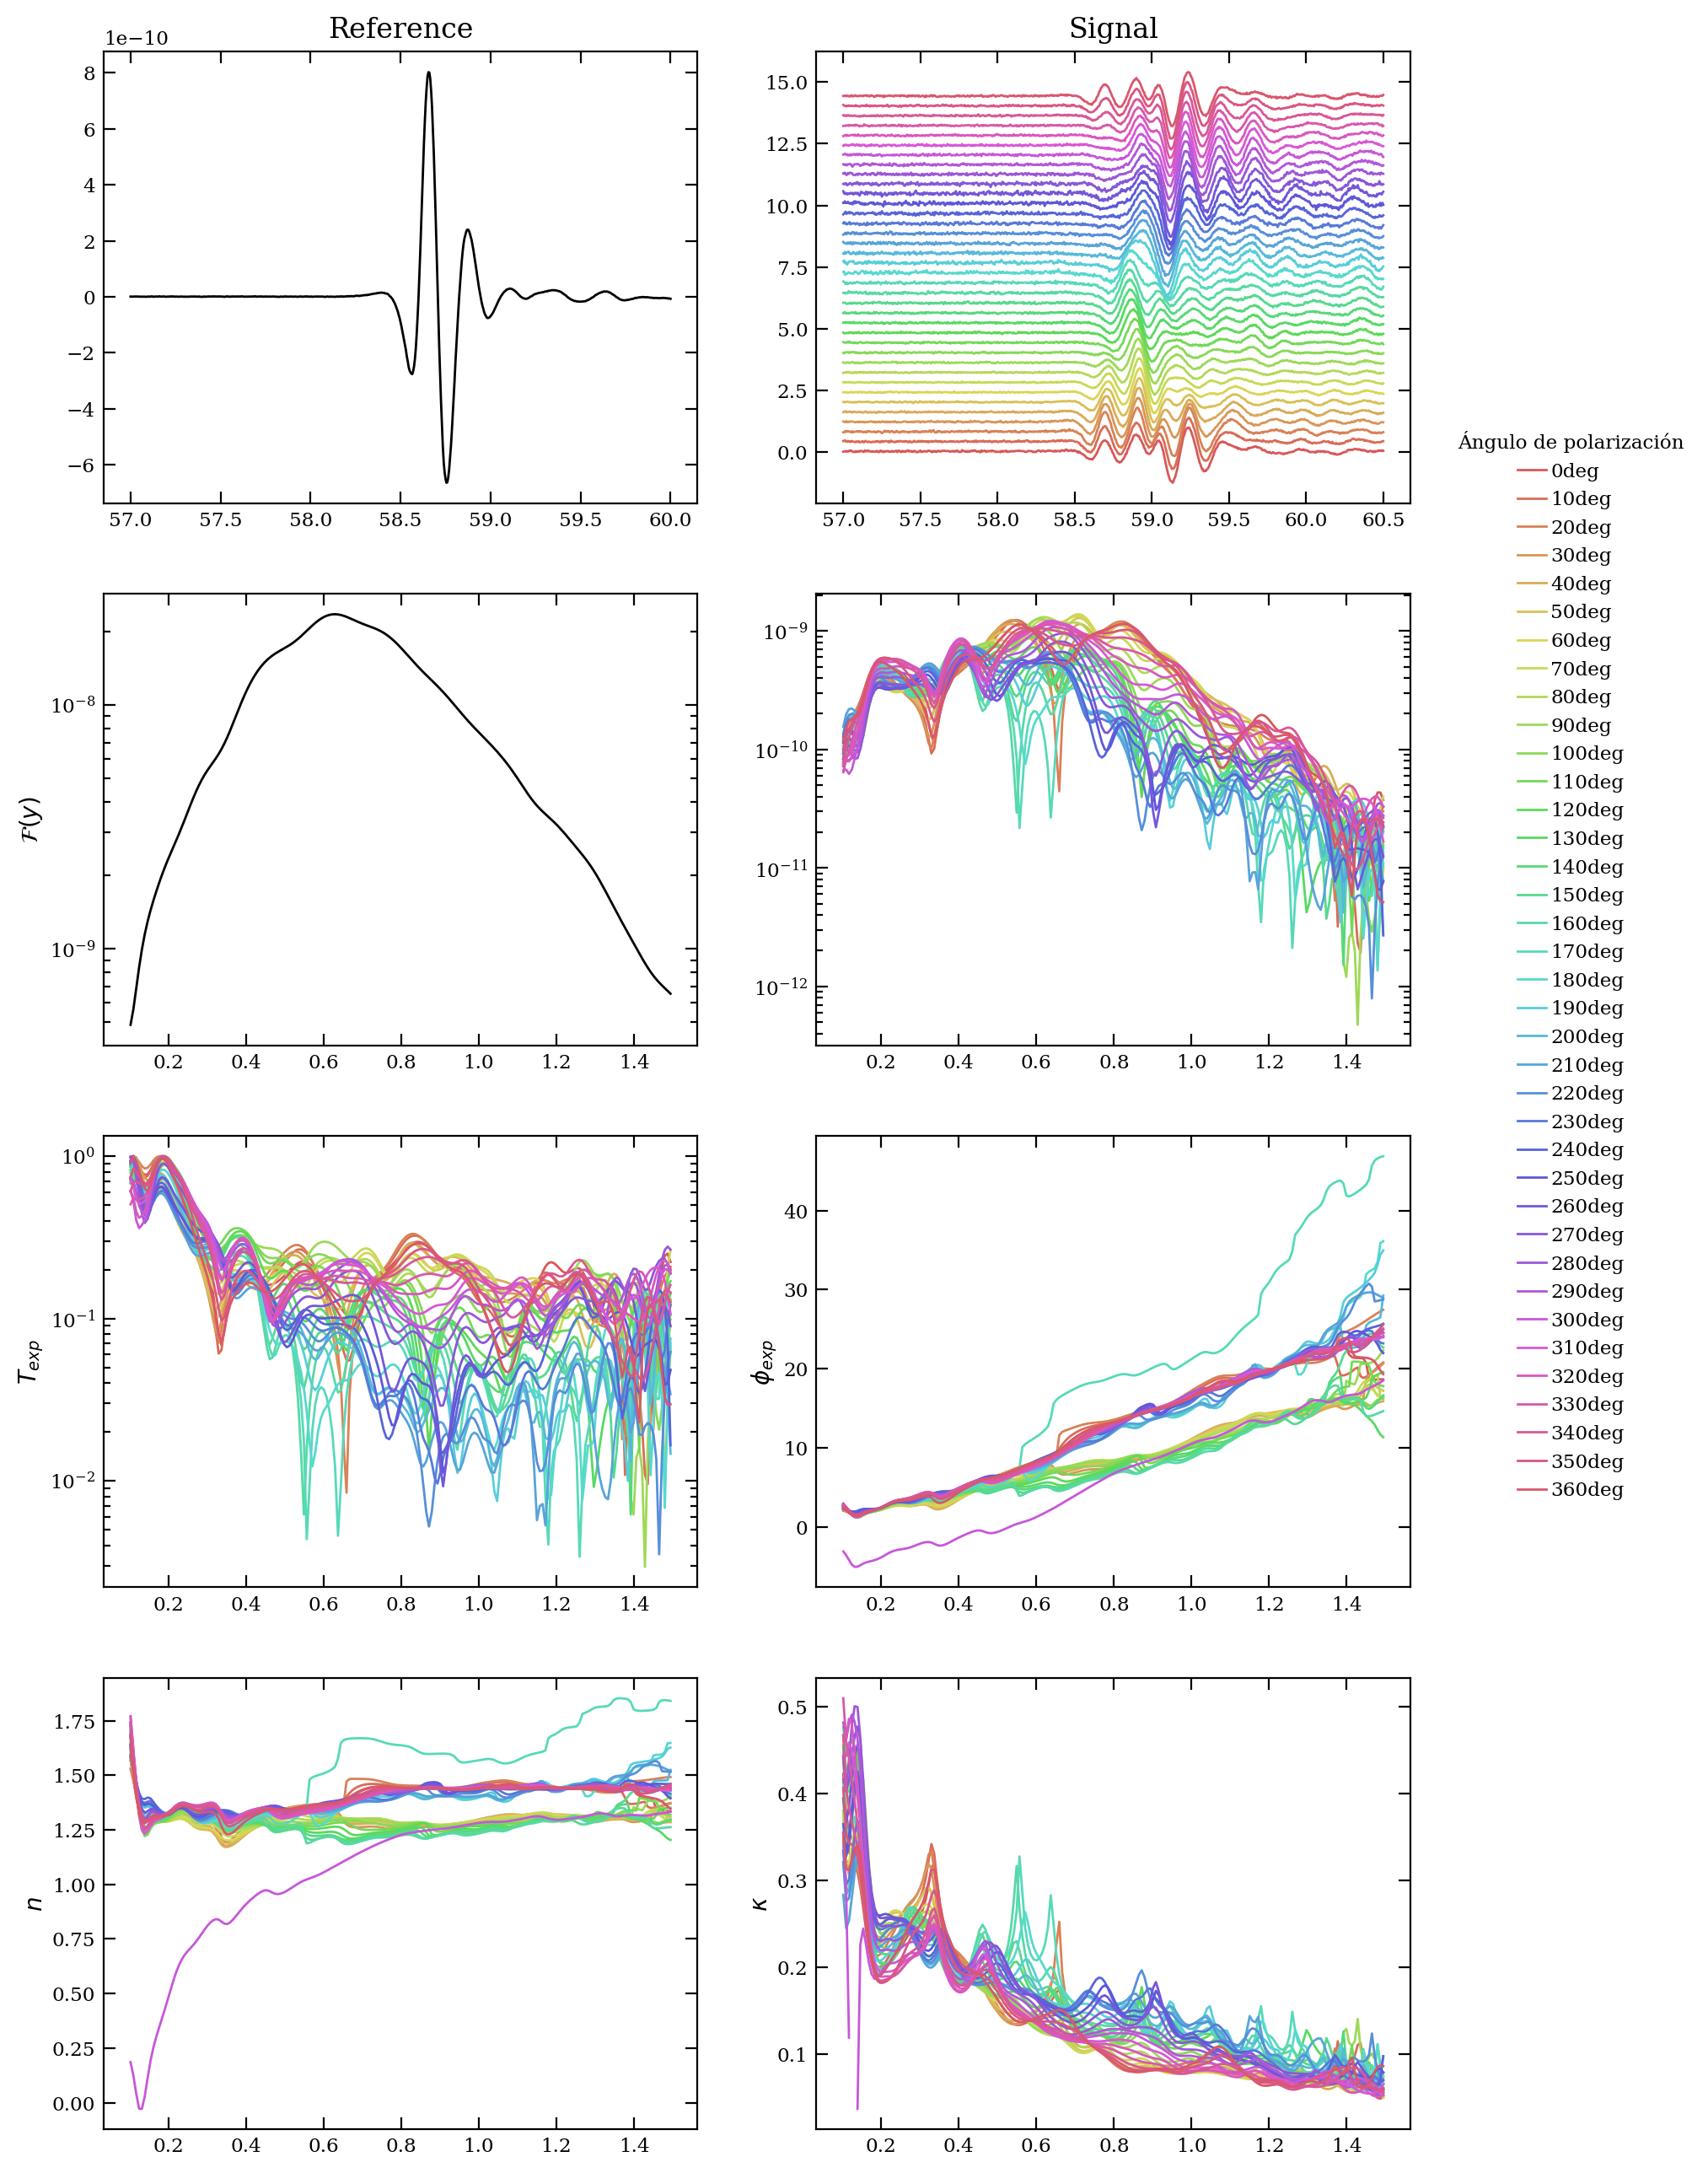

In [ ]:

right_ref= 60
left = 57
N = 2**12
d = 1.78
f = plt.figure(figsize=(10,16),dpi=200)


num_files = len(sample1_med)
angles = np.linspace(0, 360, num_files, endpoint=False)  # ángulos de 0 a 350

# Usar un mapa de colores cíclico
colors = [hsv_to_rgb([angle / 360.0, 0.6, 0.85]) for angle in angles]


plt.subplot(421)

x_ref,y_ref = getFilterdata(rutas_ref_sample1[0],right_ref,left)
plt.plot(x_ref,y_ref,'k')
plt.title("Reference")



for j,path_signal in enumerate(sample1_med):
    
    right_sample = 60.5
    left = 57

    plt.subplot(422)
    x,y = getFilterdata(path_signal,right_sample,left)
    # df1 = pd.read_csv(path_signal, delim_whitespace=True)
    # color = colormap(j / num_files)  # normalizar j al rango [0,1]
    plt.plot(x, y / max(y) + 0.4 * j, color=colors[j], label=f"{angles[j]:.0f}°")
    plt.title("Signal")

    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal
    
    fft_y_signal= FourierT2(y,N)[1:len(nu)//k]
    fft_y_subs = FourierT2(y_ref,N)[1:len(nu)//k]

    # fft_window = FourierT2(pd.Series(ventana),N)[1:len(nu)//k]

     # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.1, 1.5
    mask = (nu >= xmin) & (nu <= xmax)

    nu_filtradas = nu[mask]

    fft_y_signal= fft_y_signal[mask]
    fft_y_subs = fft_y_subs[mask]

    T = fft_y_signal/fft_y_subs
    T_exp = abs(T)
    phi_exp = np.angle(T)
    phi_exp = np.unwrap(phi_exp)

    plt.subplot(423)

    if j == 0:
        plt.plot(nu_filtradas,abs(fft_y_subs),'k',label='reference')
 
    plt.ylabel(r"$\mathcal{F}(y)$")
    plt.yscale('log')

    plt.subplot(424)
    plt.plot(nu_filtradas,abs(fft_y_signal), color=colors[j],label=angulos_sample1[j])
   
    # plt.plot(nu_filtradas,abs(T)/max(abs(T)))
    plt.yscale('log')


    plt.subplot(425)
    plt.plot(nu_filtradas,abs(T)/max(abs(T)), color=colors[j],label=angulos_sample1[j])
    plt.ylabel(r"$T_{exp}$")
    plt.yscale('log')
    

    plt.subplot(426)
    plt.plot(nu_filtradas,phi_exp, color=colors[j])
    plt.ylabel(r"$\phi_{exp}$")

    plt.subplot(427)
    n = calcular_n(nu_filtradas*2*np.pi, phi_exp, c, d)
    plt.plot(nu_filtradas,n, color=colors[j],label=angulos_sample1[j])

    plt.ylabel(r"$n$")
    
    plt.subplot(428)
    plt.ylabel(r"$\kappa$")
    plt.plot(nu_filtradas,calcular_kappa(nu_filtradas*2*np.pi, T_exp, n, c, d), color=colors[j],label=angulos_sample1[j])


plt.legend(bbox_to_anchor=(1.05, 3.8), loc='upper left', title="Ángulo de polarización")
plt.tight_layout()